In [16]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('..')
from networks import *
from utils import *

In [17]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = plt.get_cmap('cmr.bubblegum')
cmap_error = plt.get_cmap('cmr.cosmic')

In [18]:
problem = "kdv"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [42]:
import time
def F(u, u_x):
    integrand = u**3 - 0.5*u_x**2
    return integrand

In [20]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
u_test = train_val_test["test"]
scaled_data = jnp.load(data_path + problem + "_z_score.npz")

In [21]:
t_test = data["t"]
x_test = data["x"]

In [22]:
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

u_std = scaled_data["u_std"]
u_mean = scaled_data["u_mean"]
x_std = scaled_data["x_std"]
x_mean = scaled_data["x_mean"]
t_std = scaled_data["t_std"]
t_mean = scaled_data["t_mean"]

x_encoder = lambda x: (x - x_mean) / x_std
x_decoder = lambda x: x * x_std + x_mean
t_encoder = lambda t: (t - t_mean) / t_std
t_decoder = lambda t: t * t_std + t_mean
u_encoder = lambda u: (u - u_mean) / u_std
u_decoder = lambda u: u * u_std + u_mean

In [23]:
from jax import grad, value_and_grad, vmap
from traditional_solvers import Dx

In [24]:
def total_derivatives(u, x, t, F):
    """The input and output of the HINO is the same as the input of the OperatorNet.
    Input:
        x: scalar
        t: scalar
    Output:
        u_t(x,t): scalar, at x=x and t=t
    """
    dx_s = x[1] - x[0]
    dx = x_decoder(x[1])
    u = u_decoder(u) # u in original scale (function of x for ease of notation)
    u_x = Dx(u, dx, axis=1).ravel() # ∂u/∂x in original scale
    u = u.ravel()
    
    dFdu = vmap(grad(F))(u, u_x).reshape((len(t), len(x))) # ∂F/∂u in original scale
    dFdu_x = vmap(grad(F, 1))(u, u_x).reshape((len(t), len(x))) # ∂F/∂u in original scale
    
    δℋ = dFdu - Dx(dFdu_x, dx_s, axis=1)/x_std # δℋ/δu in original scale
    
    𝒢δℋ =  -Dx(δℋ, dx_s, axis=1)/x_std  # 𝒢 δℋ/δu in original scale
    
    return 𝒢δℋ

In [121]:
@eqx.filter_jit
def chain_rule_derivatives(u, x, t, F):
    """The input and output is the same as the input of the OperatorNet.
    Input:
        x: (Nx,) array
        t: scalar
    Output:
        𝒢δℋ(x,t) (= u_t(x,t)): (Nx,) array at t=t
    """
    
    u = u_decoder(u)
    u_x = Dx(u, x_decoder(x[1]), axis=1)
    u_xx = Dx(u_x, x_decoder(x[1]), axis=1)
    u_xxx = Dx(u_xx, x_decoder(x[1]), axis=1).ravel()
    
    u = u.ravel()
    u_x = u_x.ravel()
    u_xx = u_xx.ravel()
    
    # Notation: write u=y and u_x=z.
    # dF/du is then F_y, dF/du_x is F_z, etc.
    
    F_y = grad(F)
    F_yz_val = vmap(grad(F_y, 1))(u, u_x)
    F_yy_val, F_yyz_val = vmap(value_and_grad(grad(F_y), 1))(u, u_x)
    F_zz_val, (F_yzz_val ,F_zzz_val) = vmap(value_and_grad(grad(grad(F, 1), 1), (0,1)))(u, u_x)
    
    F_yx = F_yy_val * u_x  + F_yz_val * u_xx
    F_zxx = F_yz_val*u_xx + F_zz_val*u_xxx + F_yyz_val*u_x**2 + 2*F_yzz_val*u_x*u_xx+F_zzz_val * u_xx**2
                                
    𝒢δℋ = - F_yx + F_zxx
    return 𝒢δℋ.reshape((len(t), len(x)))

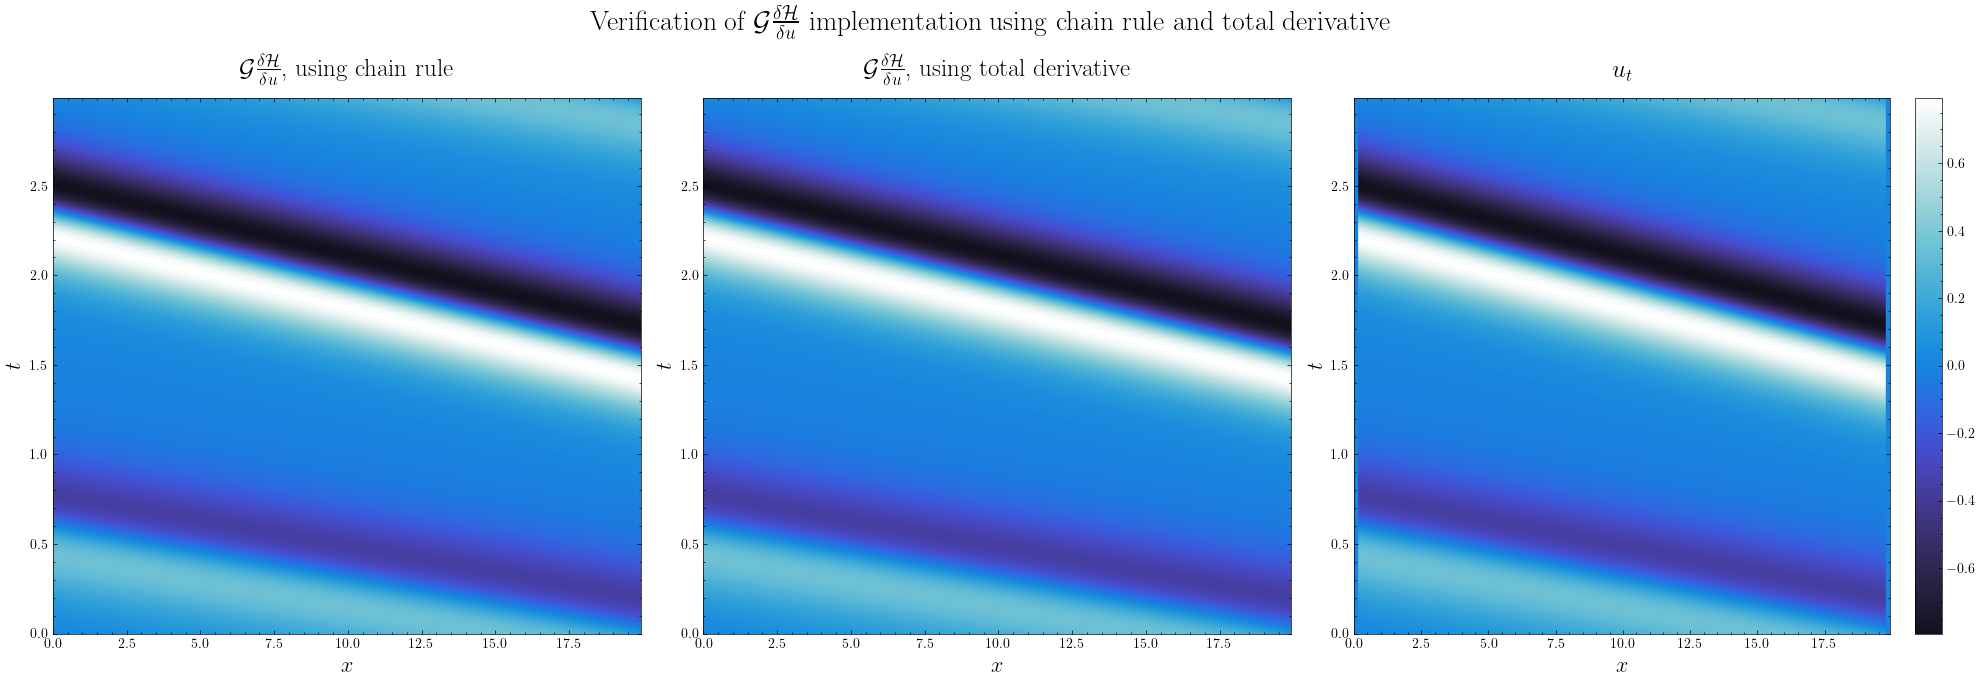

In [116]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = cmr.get_sub_cmap('cmr.freeze', 0.1, 1)

# Calculate u_t
u_t = Dx(u_decoder(u_test_s[0]), t_decoder(t_test_s[1]), axis=0)
u_t = u_t.at[:3].set(0).at[-3:].set(0)

# Determine vmin and vmax based on u_t
vmin, vmax = u_t.min(), u_t.max()

fig, axes = plt.subplots(1, 3, figsize=(20, 7), gridspec_kw={'width_ratios': [1, 1, 1]})
fig.suptitle(r'Verification of $\mathcal{G} \frac{\delta \mathcal{H}}{\delta u}$ implementation using chain rule and total derivative', fontsize=20)

# Plot the chain rule derivatives
im1 = axes[0].imshow(chain_rule_derivatives4(u_test_s[0], x_test_s, t_test_s, F).T, aspect='auto', extent=[x_test.min(), x_test.max(), t_test.min(), t_test.max()], cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title(r'$\mathcal{G} \frac{\delta \mathcal{H}}{\delta u}$, using chain rule', fontsize=18, pad=15)
axes[0].set_xlabel(r'$x$', fontsize=16)
axes[0].set_ylabel(r'$t$', fontsize=16)

# Plot the total derivatives
im2 = axes[1].imshow(total_derivatives(u_test_s[0], x_test_s, t_test_s, F).T, aspect='auto', extent=[x_test.min(), x_test.max(), t_test.min(), t_test.max()], cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title(r'$\mathcal{G} \frac{\delta \mathcal{H}}{\delta u}$, using total derivative', fontsize=18, pad=15)
axes[1].set_xlabel(r'$x$', fontsize=16)
axes[1].set_ylabel(r'$t$', fontsize=16)

# Plot the Dt derivatives
im3 = axes[2].imshow(u_t.T, aspect='auto', extent=[x_test.min(), x_test.max(), t_test.min(), t_test.max()], cmap=cmap, vmin=vmin, vmax=vmax)
axes[2].set_title(r'$u_t$', fontsize=18, pad=15)
axes[2].set_xlabel(r'$x$', fontsize=16)
axes[2].set_ylabel(r'$t$', fontsize=16)

# Create a single colorbar for all subplots
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.25)
fig.colorbar(im1, cax=cax)

plt.tight_layout()
plt.savefig("other/verification_HON_implementation.svg")
plt.show()


In [13]:
def gauss_legendre_6(f, u0, t):
    """
    Integrates the ODE system using the Gauss-Legendre method of order 6.
    Implementation follows "IV.8 Implementation of Implicit Runge-Kutta Methods" in 
    "Solving Ordinary Differential Equations II" by Hairer and Wanner

    Args:
      f: The right-hand side function of the ODE system.
      u0: Initial condition.
      dt: Time step.
      t: Array of time points.
      args: Additional arguments to pass to f.
      rtol: Relative tolerance for the nonlinear solver.
      atol: Absolute tolerance for the nonlinear solver.
      

    Returns:
      An array of solution values at the given time points.
    """
    dt = t[1] - t[0]
    
    c = jnp.array([0.5 - jnp.sqrt(15)/10, 0.5, 0.5 + jnp.sqrt(15)/10])
    A = jnp.array([[5/36, 2/9-jnp.sqrt(15)/15, 5/36-jnp.sqrt(15)/30],
                    [5/36+jnp.sqrt(15)/24, 2/9, 5/36-jnp.sqrt(15)/24],
                    [5/36+jnp.sqrt(15)/30, 2/9+jnp.sqrt(15)/15, 5/36]])
    d = jnp.array([5/3, -4/3, 5/3])
    
    @jax.jit
    def step(un, tn): 
        z0 = dt*(A[0,0]*f(tn + c[0]*dt) + A[0,1]*f(tn + c[1]*dt) + A[0,2]*f(tn + c[2]*dt))
        z1 = dt*(A[1,0]*f(tn + c[0]*dt) + A[1,1]*f(tn + c[1]*dt) + A[1,2]*f(tn + c[2]*dt))
        z2 = dt*(A[2,0]*f(tn + c[0]*dt) + A[2,1]*f(tn + c[1]*dt) + A[2,2]*f(tn + c[2]*dt))
        z_next = jnp.array([z0, z1, z2])
    
        u_next = un + jnp.dot(d, z_next)
            
        return u_next, un

    _, u_arr = jax.lax.scan(step, u0, t)
    return u_arr

def u_integrated_gauss(u, x, t, F):
    """Since the model predicts 𝒢δℋ (=u_t),
    we have to integrate the prediction to get u.

    Args:
        a (Mp1,): initial condition
        x (Mp1,): spatial grid
        t (Np1,): temporal grid

    Returns:
        u (Np1, Mp1): prediction for the given grid
    """
    # predict 𝒢δℋ (=u_t) for all x, at scalar t
    𝒢δℋ_whole_grid = total_derivatives(u, x, t, F)
    decoded_t = t_decoder(t)
    𝒢δℋ = lambda t_value : 𝒢δℋ_whole_grid[jnp.argmin(jnp.abs(decoded_t - t_value))]
    u0 = u_decoder(u[0])
    return gauss_legendre_6(𝒢δℋ, u0, decoded_t)

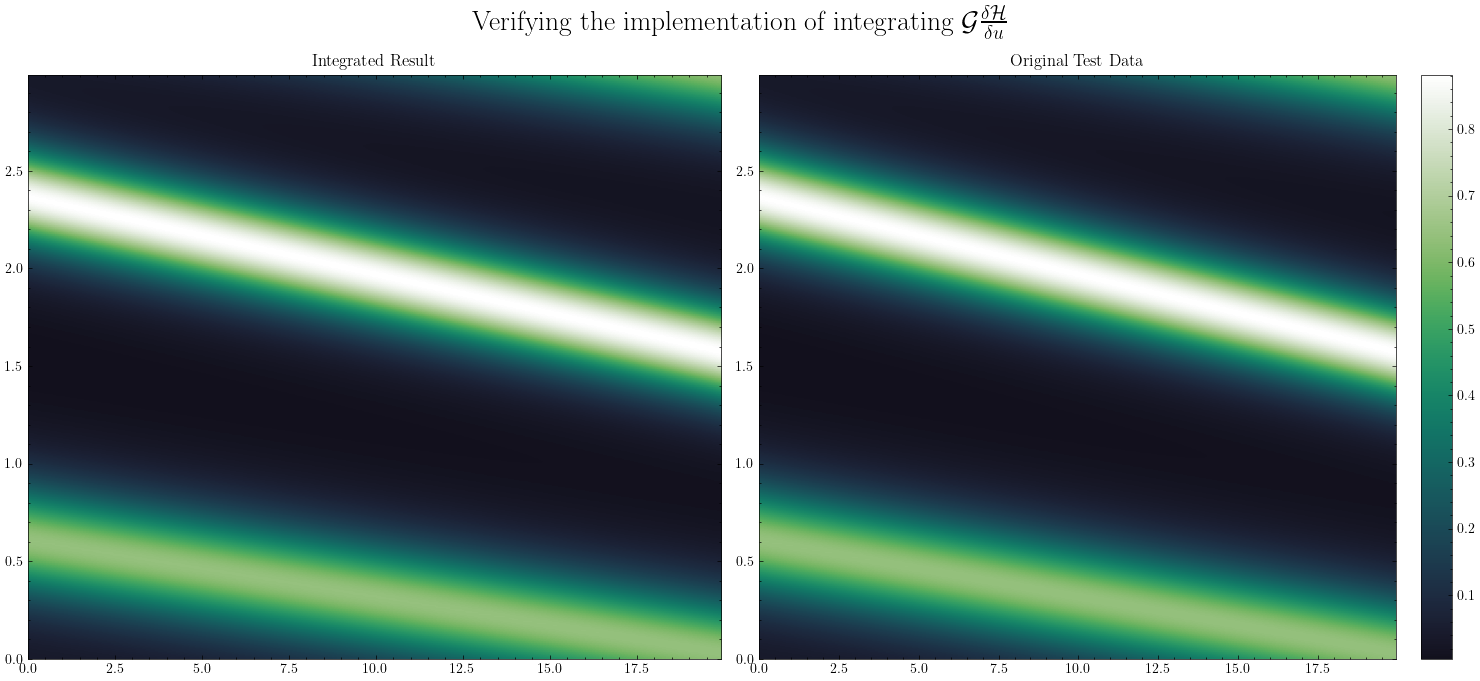

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

cmap = cmr.get_sub_cmap('cmr.swamp', 0.1, 1)
vmin, vmax = u_test[0].min(), u_test[0].max()

fig.suptitle(r'Verifying the implementation of integrating $\mathcal{G} \frac{\delta \mathcal{H}}{\delta u}$', fontsize=20)

# Plot the integrated result
im1 = axes[0].imshow(u_integrated_gauss(u_test_s[0], x_test_s, t_test_s, F).T, aspect='auto', extent=[x_test.min(), x_test.max(), t_test.min(), t_test.max()], cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Integrated Result')

# Plot the original test data
im2 = axes[1].imshow(u_test[0].T, aspect='auto', extent=[x_test.min(), x_test.max(), t_test.min(), t_test.max()], cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('Original Test Data')

# Create a single colorbar for all subplots
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.25)
fig.colorbar(im1, cax=cax)

plt.tight_layout()
plt.savefig("other/verification_gauss_integration.svg")
plt.show()